In [356]:
import YouTube_Data_Story as ds
import YouTube_Data_Wrangling as dw
from matplotlib.gridspec import GridSpec
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import math
import requests
import matplotlib as mpl
from matplotlib.ticker import FuncFormatter
from scipy.stats import t, ttest_ind_from_stats
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

In [367]:
#DataFrames
df_usa=dw.combined_usa_mx_df[dw.combined_usa_mx_df.country=='USA']
df_mx=dw.combined_usa_mx_df[dw.combined_usa_mx_df.country=='Mexico']


df_usa_views_log=np.log10(df_usa['views']+1)
df_usa_likes_log=np.log10(df_usa['likes']+1)
df_usa_dlikes_log=np.log10(df_usa['dislikes']+1)
df_usa_comments_log=np.log10(df_usa['comment_count']+1)



(35726,)

In [358]:
#FUNCTIONS:

def ecdf(data):
    x=np.sort(data)
    y=np.arange(1,len(x)+1)/len(x)
    _=plt.plot(x,y,marker='.',linestyle='none')  

####  Scenario 1:
For YouTube (Client) to consider investing properly in people, infrastructure etc, they need to know audience engagement with the videos in both countries. 
For this they need to know the views/likes/dislikes/comment_count distribution and a 95% confidence interval around the population mean. 
We consider df_usa_views to be a sample and we are inferening population statistics for all the video views across all categories in USA. 


.95% of the views for USA are under: 8.89M
.The PEAK of the distribution is closer to it's median 0.67M, rather than mean 2.33M
...This is expected behavior from a left skewed distribution
.Other statistics of the views in the USA:
.Mean= 2.33M
.Standard Error ~ STD population = 7.26M
.Median= 0.67M
.Margin_Error= -0.06M
.CI_left= 2.26M
>>>>>>>>>>>>>>>


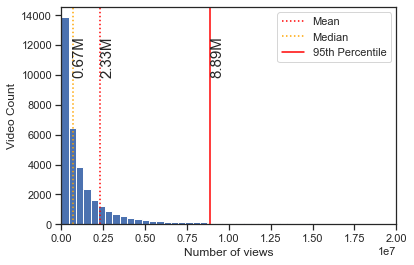

In [370]:
#Finding population statistics of the "views" in the USA

# 1. Finding Standard Deviation (Stabdard Error), Mean, Median, 95th Percentile, CI_lower_end, Margin of Error for 
# the distribution df_usa['views']

std=np.std(df_usa['views'], ddof=1)
mean=np.mean(df_usa['views'])
median=np.median(df_usa['views'])
percent95= np.percentile(df_usa['views'], 95)

#2. Using t-table (because it's one sided hist) calculating ME, CI
#Keeping alpha = 0.05

p=0.05
size=len(df_usa)
df=size -1
t_critical = t.ppf(p, df)

SE=std/np.sqrt(size)
ME=t_critical * SE
CI_lower_end=mean+ME


# 2. Plotting hist distribution of 'views' in USA

_=plt.hist(df_usa['views'], bins=500)
#Almost all of the videos in USA got views under 20 million mark therefore I set the xlim(0, 20Million)
_=plt.xlim([0, 20000000]) #20 million
_=plt.xlabel("Number of views")
_=plt.ylabel("Video Count")

#Mean
_=plt.axvline(mean, color='red', linestyle=':', label='Mean')

_=plt.text(mean,10000,'{:,.2f}M' .format(mean/1000000),rotation=90, fontsize=15)

#Median
_=plt.axvline(median, color='orange', linestyle=':', label='Median')

_=plt.text(median,10000,'{:,.2f}M' .format(median/1000000),rotation=90, fontsize=15)


#95th percentile data
_=plt.axvline(percent95, color='red', label='95th Percentile')
_=plt.text(percent95,10000,'{:,.2f}M' .format(percent95/1000000),rotation=90, fontsize=15)
_=plt.legend(loc=0)

#Commentary

print(".95% of the views for USA are under: " + '{:,.2f}M' .format(percent95/1000000))
print(".The PEAK of the distribution is closer to it's median {:,.2f}M, rather than mean {:,.2f}M".format(median/1000000, mean/1000000))
print("...This is expected behavior from a left skewed distribution")
print(".Other statistics of the views in the USA:")
print('.Mean= {:,.2f}M'.format(mean/1000000))
print('.Standard Error ~ STD population = {:,.2f}M'.format(std/1000000))
print('.Median= {:,.2f}M'.format(median/1000000))
print('.Margin_Error= {:,.2f}M'.format(ME/1000000))
print('.CI_left= {:,.2f}M'.format(CI_lower_end/1000000))
print('>>>>>>>>>>>>>>>')


## Analysis:
####If I were to tell YouTube(client), how enagaged USA audiences are I need to first find statistics on a normal distribution of the sample. Since its clearly not, Central Limit Theorm (CLT) states if three conditions are met then the distribution will depict normal distribution. (they do!!)
#### 1. Random Samples (YES!!), 2. Independent conditions(Number of views from one video doesnt effect views of other videos), 3. Normal condition i.e. >=10 succ and failures. 
#### Report: On average the videos get 2.33M views (total videos in USA sample: 35726)
### The median of these average views is 0.67M 
## There are outliers that make Mean way more than majority of the video views
## The histogram shows that majority of the views are around median (0.67M)of the sample data rather than mean
##### Will add analysis based on CI with mean after talking to Ana